## XGBoost模型参数调节

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194592 entries, 0 to 194591
Columns: 133 entries, id to Unnamed: 132
dtypes: float64(15), int64(1), object(117)
memory usage: 197.5+ MB


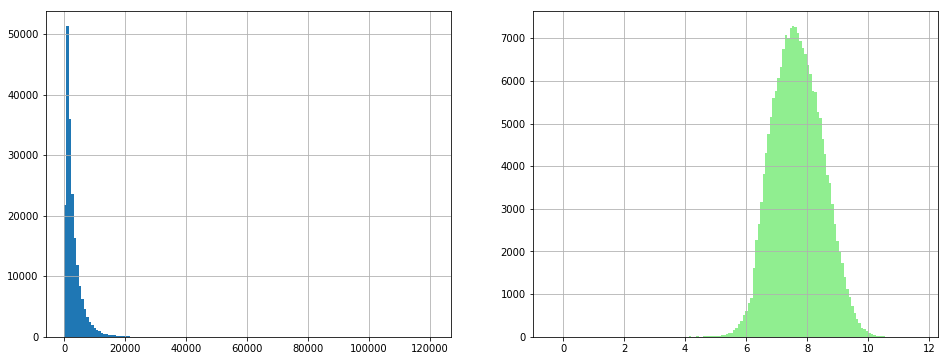

Wall time: 0 ns
CV score: 1218.707601


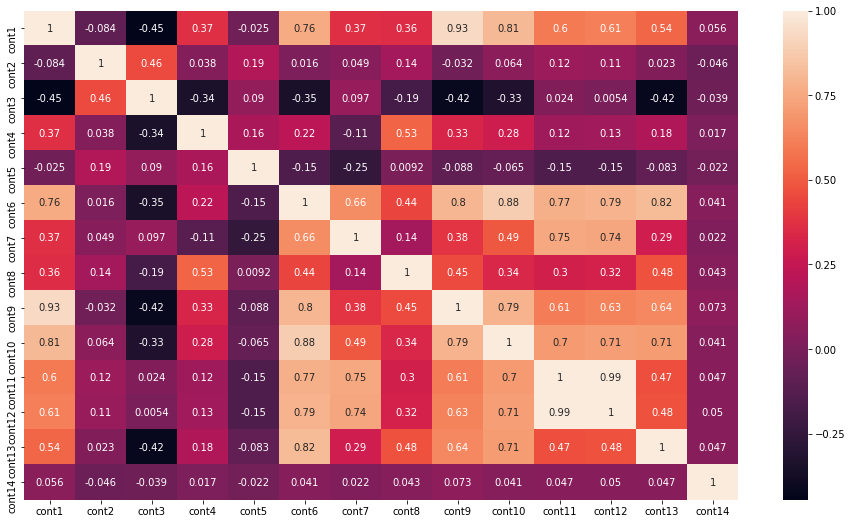

<Figure size 432x288 with 0 Axes>

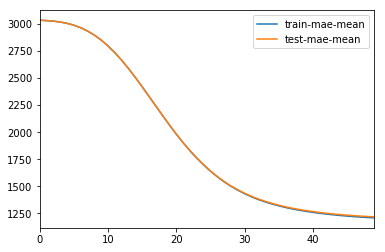

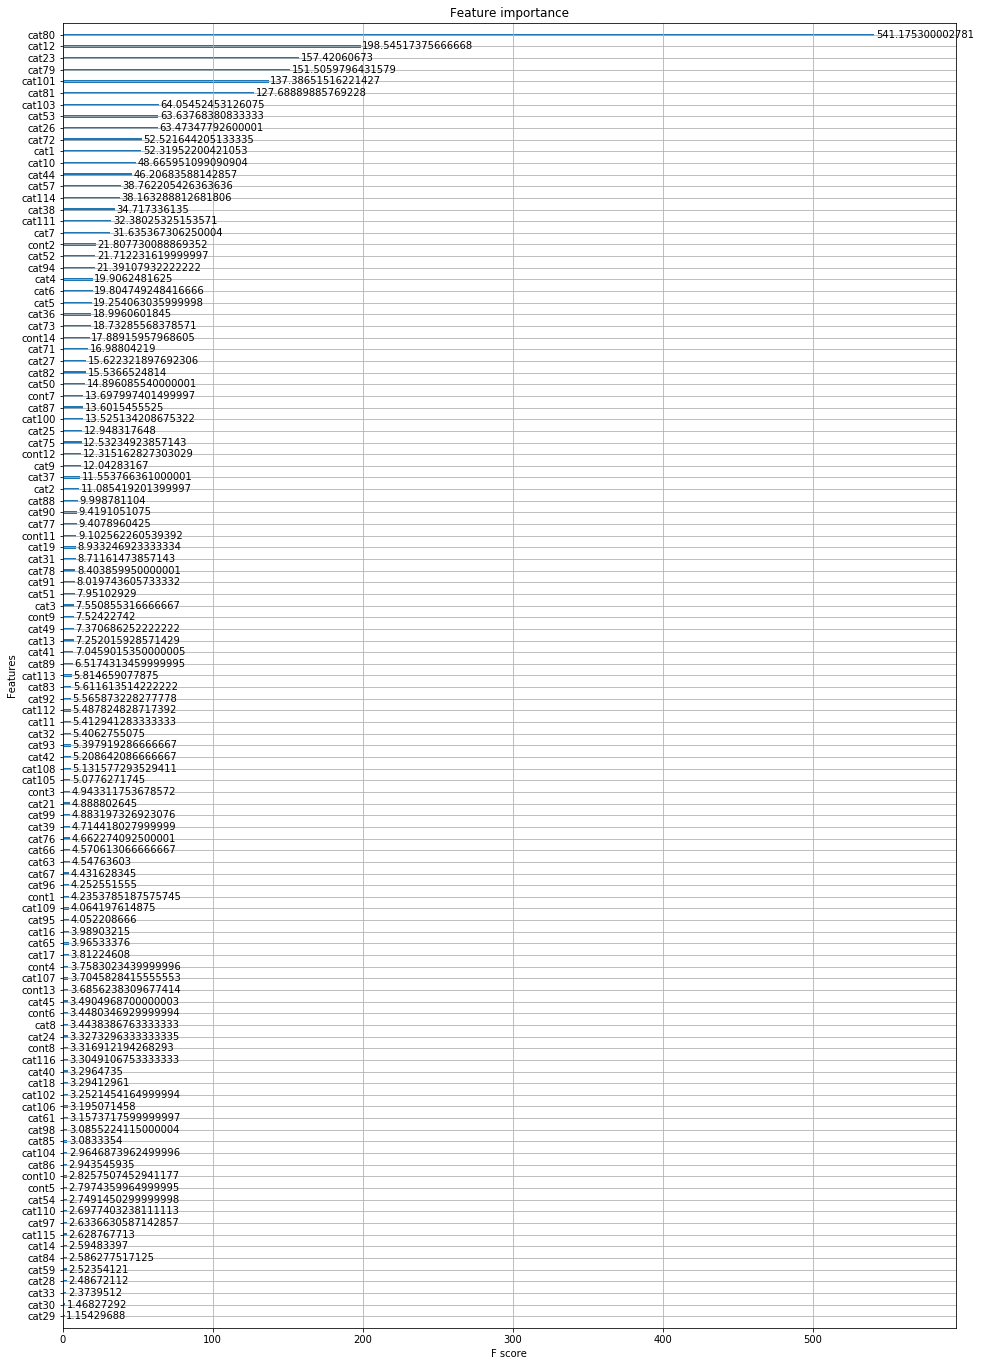

[0]	validation_0-mae:5.03315
[1]	validation_0-mae:3.52441
[2]	validation_0-mae:2.46875
[3]	validation_0-mae:1.73314
[4]	validation_0-mae:1.22890
[5]	validation_0-mae:0.89968
[6]	validation_0-mae:0.70082
[7]	validation_0-mae:0.58726
[8]	validation_0-mae:0.52389
[9]	validation_0-mae:0.49110
[10]	validation_0-mae:0.47150
[11]	validation_0-mae:0.45979
[12]	validation_0-mae:0.45397
[13]	validation_0-mae:0.44819
[14]	validation_0-mae:0.44561
[15]	validation_0-mae:0.44310
[16]	validation_0-mae:0.44140
[17]	validation_0-mae:0.43986
[18]	validation_0-mae:0.43853
[19]	validation_0-mae:0.43717
[20]	validation_0-mae:0.43636
[21]	validation_0-mae:0.43491
[22]	validation_0-mae:0.43436
[23]	validation_0-mae:0.43339
[24]	validation_0-mae:0.43303
[25]	validation_0-mae:0.43251
[26]	validation_0-mae:0.43192
[27]	validation_0-mae:0.43135
[28]	validation_0-mae:0.43086
[29]	validation_0-mae:0.43049
[30]	validation_0-mae:0.43008
[31]	validation_0-mae:0.42950
[32]	validation_0-mae:0.42926
[33]	validation_0-ma

<Figure size 432x288 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
#凡是sklearn.cross_validation找不到的问题，都改为model_selection
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%run Allstate_Claim_Severity-1.py

**分种类、分组调节参数，每调节一组参数维持其他参数不变**
* **Step1 :** 选择一组初始参数
* **Step2 :** 调节max_depth和min_child_weight.(树结构复杂程度的参数)
* **Step3 :** 调节gamma降低模型过拟合风险.(range: [0,∞])
* **Step4 :** 调节subsample和colsample_bytree改变数据采样策略.
* **Step5 :** 调节学习率eta.(加法模型增加每棵树时所占的权重)

In [2]:
class XGBoostRegressor(object): #object类似继承了object类的意思
    #参数'**kwargs'中的'**'是以字典形式传入的意思
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
            self.params.pop('num_boost_round')
        else:
            self.num_boost_round = 50
            
        self.params.update({'objective' : 'reg:squarederror', 'seed' : 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params = self.params, dtrain = dtrain, num_boost_round = self.num_boost_round, feval = eval_mae, maximize = False)
    
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold = 5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params = self.params, dtrain = dtrain, num_boost_round = self.num_boost_round, nfold = nfold, feval = eval_mae, maximize = False)
        return cv_rounds.iloc[-1, :]
    
    def get_params(self, deep = True):
        return self.params
    
    def set_params(self, **params):
        self.params.update(params)
        return self

In [3]:
def sk_eval_mae(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

In [4]:
#sklearn的make_score方法，用于制造scoring参数的值，可生成除备选字符串之外的自定义方法
mae_scorer = make_scorer(sk_eval_mae, greater_is_better = False)

In [5]:
bst = XGBoostRegressor(eta = 0.1, colsample_bytree = 0.5, subsample = 0.5, max_depth = 5, min_child_weight = 3, num_boost_round = 50)

In [6]:
bst.kfold(X, y, nfold = 5)

train-rmse-mean       0.559176
train-rmse-std        0.000400
test-rmse-mean        0.562705
test-rmse-std         0.001672
train-mae-mean     1210.161401
train-mae-std         1.585580
test-mae-mean      1218.723926
test-mae-std          5.596474
Name: 49, dtype: float64

## Step2: 树的深度和节点权重
max_depth和min_child_weight参数对XGBoost性能影响最大，应该第一个调整。
* max_depth：树的最大深度，3-10之间是合理的

In [7]:
xgb_param_grid = {'max_depth' : list(range(4, 9)), 'min_child_weight' : list((1, 3, 6))}

In [8]:
grid = GridSearchCV(XGBoostRegressor(eta = 0.1,
                                     num_boost_round = 10,
                                     colsample_bytree = 0.5,
                                     subsample = 0.5),
                    param_grid = xgb_param_grid,
                    cv = 5,
                    scoring = mae_scorer)

grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<__main__.XGBoostRegressor object at 0x000001688504A898>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [4, 5, 6, 7, 8], 'min_child_weight': [1, 3, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(sk_eval_mae, greater_is_better=False),
       verbose=0)

In [12]:
grid.best_params_, grid.best_score_

({'max_depth': 8, 'min_child_weight': 6}, -1188.214175363066)

In [13]:
grid.best_estimator_

## Step3: 调节gamma($\gamma$)

In [14]:
xgb_param_grid = {'gamma' : [0.1 * x for x in range(0, 5)]}
grid = GridSearchCV(XGBoostRegressor(eta = 0.1,
                                     num_boost_round = 50,
                                     max_depth = 8,
                                     min_child_weight = 6,
                                     colsample_bytree = 0.5,
                                     subsample = 0.5),
                    param_grid = xgb_param_grid,
                    cv = 5,
                    scoring = mae_scorer)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<__main__.XGBoostRegressor object at 0x0000016885012A90>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(sk_eval_mae, greater_is_better=False),
       verbose=0)

In [15]:
#就这个数据集来说，gamma的调节对结果影响很小
grid.best_params_, grid.best_score_

({'gamma': 0.30000000000000004}, -1187.9235945077578)

## Step4: 调节样本采样方式subsample和colsample_bytree

In [17]:
xgb_param_grid = {'subsample' : [0.1 * x for x in range(6, 9)], 'colsample_bytree' : [0.1 * x for x in range(6, 9)]}
grid = GridSearchCV(XGBoostRegressor(eta = 0.1,
                                     num_boost_round = 50,
                                     max_depth = 8,
                                     min_child_weight = 6,
                                     gamma = 0.3), 
                   param_grid = xgb_param_grid,
                    cv = 5,
                    scoring = mae_scorer)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<__main__.XGBoostRegressor object at 0x0000016884AA16D8>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'subsample': [0.6000000000000001, 0.7000000000000001, 0.8], 'colsample_bytree': [0.6000000000000001, 0.7000000000000001, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(sk_eval_mae, greater_is_better=False),
       verbose=0)

In [18]:
#就这个数据集来说，subsample和colsample_bytree的调节对结果影响很小
grid.best_params_, grid.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.7000000000000001},
 -1183.0580862017687)

## Step5: 减小学习率eta并且增加树的个数

In [19]:
xgb_param_grid = {'eta' : [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round = 50,
                                     max_depth = 8,
                                     min_child_weight = 6,
                                     gamma = 0.3,
                                     colsample_bytree = 0.8,
                                     subsample = 0.8), 
                   param_grid = xgb_param_grid,
                   cv = 5,
                   scoring = mae_scorer)
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<__main__.XGBoostRegressor object at 0x0000016884AB39E8>,
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(sk_eval_mae, greater_is_better=False),
       verbose=0)

In [20]:
grid.best_params_, grid.best_score_

({'eta': 0.2}, -1160.6573707973203)

<font size = 4, color = 'red'>好的特征决定了模型的上限，调参只是决定了如何逼近这个上限</font>